In [3]:
import pandas as pd

# Load the datasets
energy_balance_df = pd.read_csv('EnergyBalanceDataset.csv')
goal7_df = pd.read_csv('cleanedDataGoal7.csv')
energy_investments_df = pd.read_excel('EnergyInvestmentsData.xlsx')

# Display the first few rows of each dataset to understand their structure
energy_balance_df.head(), goal7_df.head(), energy_investments_df.head()


(     Country                   Product                                   Flow  \
 0  Australia  Coal, peat and oil shale                        Production (PJ)   
 1  Australia  Coal, peat and oil shale                           Imports (PJ)   
 2  Australia  Coal, peat and oil shale                           Exports (PJ)   
 3  Australia  Coal, peat and oil shale               Total energy supply (PJ)   
 4  Australia  Coal, peat and oil shale  Electricity, CHP and heat plants (PJ)   
 
        NoCountry                     NoProduct  \
 0  01. Australia  01. Coal, peat and oil shale   
 1  01. Australia  01. Coal, peat and oil shale   
 2  01. Australia  01. Coal, peat and oil shale   
 3  01. Australia  01. Coal, peat and oil shale   
 4  01. Australia  01. Coal, peat and oil shale   
 
                                       NoFlow  1971  1972  1973  1974  ...  \
 0                        01. Production (PJ)  1368  1648  1685  1640  ...   
 1                           02. Imports (

In [5]:
electricity_data = energy_balance_df[energy_balance_df['Product'] == 'Electricity']
# Convert relevant columns to numeric if necessary and handle errors
electricity_data.loc[:, '2000':'2021'] = electricity_data.loc[:, '2000':'2021'].apply(pd.to_numeric, errors='coerce')

# Recalculate the sum to filter non-zero rows
electricity_data_nonzero = electricity_data.loc[:, '2000':'2021'].sum(axis=1)
electricity_data[electricity_data_nonzero > 0].head()



,Country,Product,Flow,NoCountry,NoProduct,NoFlow,1971,1972,1973,1974,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
76,Australia,Electricity,"Electricity, CHP and heat plants (PJ)",01. Australia,07. Electricity,"05. Electricity, CHP and heat plants (PJ)",191,200,232,251,...,903,897,891,905,923,928,939,949,953,954
78,Australia,Electricity,Total final consumption (PJ),01. Australia,07. Electricity,07. Total final consumption (PJ),163,172,189,209,...,761,761,755,768,774,767,774,779,780,779
79,Australia,Electricity,Industry (PJ),01. Australia,07. Electricity,08. Industry (PJ),71,73,83,96,...,293,292,293,284,286,277,280,281,280,283
80,Australia,Electricity,Transport (PJ),01. Australia,07. Electricity,09. Transport (PJ),2,2,2,3,...,15,16,16,20,22,21,21,23,23,23
81,Australia,Electricity,Residential (PJ),01. Australia,07. Electricity,10. Residential (PJ),60,65,67,71,...,221,218,209,203,208,213,212,218,227,236


In [6]:
# Refine the selection to "Total final consumption (PJ)"
global_electricity_consumption = electricity_data[electricity_data['Flow'] == 'Total final consumption (PJ)']

# Focus on years from 2000 to 2021 and convert PJ to TWh
global_electricity_consumption = global_electricity_consumption.loc[:, '2000':'2021'].apply(lambda x: x * 0.277778)

# Sum the data across all countries to get global consumption totals
total_global_consumption = global_electricity_consumption.sum()

total_global_consumption.head()


2000    59185.602904
2001    59991.992438
2002    62171.716404
2003    64637.273932
2004    67510.331786
dtype: object

In [8]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Prepare data
consumption_years = np.arange(2000, 2022)
consumption_values = total_global_consumption.values.astype(float)

# Fit ARIMA model for consumption (auto ARIMA could be used to select optimal parameters, but let's start with simple assumptions)
arima_model_consumption = ARIMA(consumption_values, order=(1, 1, 1))
arima_results_consumption = arima_model_consumption.fit()

# Forecast consumption from 2022 to 2030
forecast_consumption = arima_results_consumption.get_forecast(steps=9)
forecast_consumption_mean = forecast_consumption.predicted_mean

# Convert forecast index to years
forecast_consumption_years = np.arange(2022, 2031)

# Combine historical and forecasted data
full_consumption_years = np.concatenate([consumption_years, forecast_consumption_years])
full_consumption_values = np.concatenate([consumption_values, forecast_consumption_mean])

full_consumption_years, full_consumption_values


C:\Users\chand\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\chand\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
        2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
        2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]),
 array([ 59185.602904  ,  59991.992438  ,  62171.716404  ,  64637.273932  ,
         67510.331786  ,  70768.945504  ,  73790.059032  ,  77528.673134  ,
         78737.56299   ,  78173.395872  ,  83487.844568  ,  86158.957816  ,
         88298.959528  ,  91042.017278  ,  93460.908102  ,  94351.46437   ,
         97241.466682  , 100430.913678  , 105082.861844  , 106459.251834  ,
        106509.529652  , 112665.090132  , 115193.98657474, 117722.74519676,
        120251.36600556, 122779.84900866, 125308.19421357, 127836.4016278 ,
        130364.47125885, 132892.40311424, 135420.19720147]))

In [10]:
# Prepare data for generation
generation_years = np.array(global_generation.index)
generation_values = global_generation.values.astype(float)

# Fit ARIMA model for generation
arima_model_generation = ARIMA(generation_values, order=(1, 1, 1))
arima_results_generation = arima_model_generation.fit()

# Recalculate the steps required for forecasting from 2021 to 2030
forecast_steps = 2030 - 2020

# Forecast generation using the ARIMA model
forecast_generation = arima_results_generation.get_forecast(steps=forecast_steps)
forecast_generation_mean = forecast_generation.predicted_mean

# Combine historical and forecasted generation data
forecast_generation_years = np.arange(2021, 2031)
full_generation_years = np.concatenate([generation_years, forecast_generation_years])
full_generation_values = np.concatenate([generation_values, forecast_generation_mean])

full_generation_years, full_generation_values


(array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
        2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
        2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030], dtype=int64),
 array([13485.97415376, 13654.24415376, 14138.12415376, 14625.88415376,
        15343.55415376, 15937.42415376, 16549.81415376, 17403.27415376,
        17646.39415376, 17569.72415376, 18807.19415376, 19466.15415376,
        19939.03415376, 20565.48415376, 21148.62415376, 21350.08415376,
        21920.65415376, 22603.38415376, 23537.40415376, 23864.41415376,
        23744.06415376, 24251.35432901, 24758.58251156, 25265.748709  ,
        25772.85292888, 26279.89517879, 26786.8754663 , 27293.79379898,
        27800.65018441, 28307.44463015, 28814.17714377]))

In [20]:
print(arima_results_generation.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   21
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -144.710
Date:                Thu, 02 May 2024   AIC                            295.420
Time:                        01:49:32   BIC                            298.407
Sample:                             0   HQIC                           296.003
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.009    116.842      0.000       0.983       1.017
ma.L1         -0.9904      0.337     -2.935      0.003      -1.652      -0.329
sigma2      1.064e+05   3.21e-06   3.31e+10      0.0

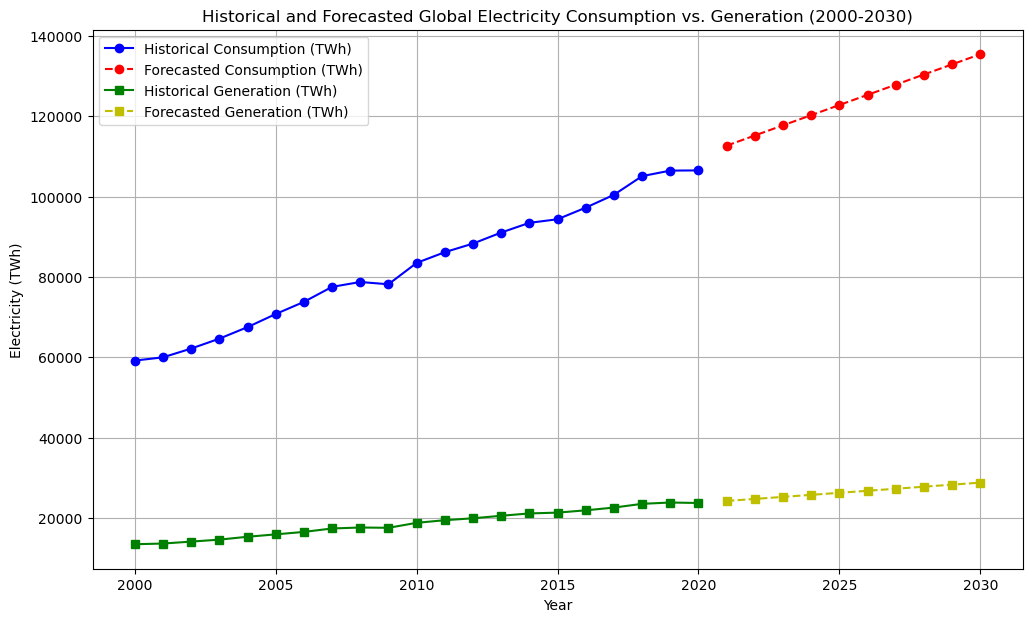

In [15]:
import matplotlib.pyplot as plt

# Define the breakpoint year where forecast begins
breakpoint_year = 2021

# Historical and forecasted indices for consumption
historical_idx_consumption = full_consumption_years < breakpoint_year
forecasted_idx_consumption = full_consumption_years >= breakpoint_year

# Historical and forecasted indices for generation
historical_idx_generation = full_generation_years < breakpoint_year
forecasted_idx_generation = full_generation_years >= breakpoint_year

# Create the updated plot with specified styles
plt.figure(figsize=(12, 7))
# Consumption
plt.plot(full_consumption_years[historical_idx_consumption], full_consumption_values[historical_idx_consumption], 'bo-', label='Historical Consumption (TWh)')
plt.plot(full_consumption_years[forecasted_idx_consumption], full_consumption_values[forecasted_idx_consumption], 'ro--', label='Forecasted Consumption (TWh)')
# Generation
plt.plot(full_generation_years[historical_idx_generation], full_generation_values[historical_idx_generation], 'gs-', label='Historical Generation (TWh)')
plt.plot(full_generation_years[forecasted_idx_generation], full_generation_values[forecasted_idx_generation], 'ys--', label='Forecasted Generation (TWh)')

plt.title('Historical and Forecasted Global Electricity Consumption vs. Generation (2000-2030)')
plt.xlabel('Year')
plt.ylabel('Electricity (TWh)')
plt.legend()
plt.grid(True)
plt.show()
